# Imports and Drive Mount


In [ ]:
!pip install Levenshtein

In [ ]:
# Standard library imports
import os
import csv

# Third-party library imports
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import Levenshtein

# TensorFlow and Keras imports
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, BatchNormalization, Activation, Reshape,
                                     Dense, LSTM, Bidirectional, Flatten, Dropout, Lambda)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split

# Display TensorFlow version
print(f'TensorFlow Version: {tf.__version__}')


TensorFlow Version: 2.15.0


In [ ]:
# Check if Google Drive is mounted
if not os.path.exists('/content/drive'):
    from google.colab import drive
    drive.mount('/content/drive')
else:
    print("Google Drive is already mounted.")

Google Drive is already mounted.


# Load the Tf Record data

*   Images arre grayscale



In [ ]:
def parse_tfrecord_fn(example):
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.VarLenFeature(tf.int64),
    }
    example = tf.io.parse_single_example(example, feature_description)
    image = tf.io.decode_jpeg(example['image'], channels=1)
    image = tf.image.convert_image_dtype(image, tf.uint8)  # Convert image to uint8
    label = tf.sparse.to_dense(example['label'])
    return image, label


# Function to load TFRecord dataset
def load_tfrecord_dataset(file_path):
    dataset = tf.data.TFRecordDataset(file_path)
    dataset = dataset.map(parse_tfrecord_fn)
    return dataset


# Function to load the maximum sequence length
def load_max_sequence_length(file_path):
    with open(file_path, "r") as f:
        line = f.readline().strip()
        max_sequence_length = int(line.split(": ")[1])
    return max_sequence_length


def display_image(image, label):
    image_np = (tf.squeeze(image) * 255).numpy().astype(np.uint8)  # Convert image back to uint8
    label_np = label.numpy()

    print(f"Label: {label_np}")

    plt.imshow(image_np, cmap='gray')
    plt.axis('off')
    plt.show()


# Define paths
tfrecord_file = '/content/drive/MyDrive/CLE/PdfOcr Training/Datasets/tf_Records/dataset_30k.tfrecord'
max_label_length_file = '/content/drive/MyDrive/CLE/PdfOcr Training/Datasets/tf_Records/max_label_length.txt'


In [ ]:
# Load TFRecord dataset
dataset = load_tfrecord_dataset(tfrecord_file)

In [ ]:
# Load maximum sequence length
max_str_len = load_max_sequence_length(max_label_length_file)
print(f"Max Sequence Length: {max_str_len}")

Max Sequence Length: 112


Type Label : <class 'tensorflow.python.framework.ops.EagerTensor'>
Label: [ 40  72   8  96  28  96   7  18  71   1  15  40  49  14 119  16   3  15
   4  49  14   7  45  16  23  93  14   2 999 999 999 999 999 999 999 999
 999 999 999 999 999 999 999 999 999 999 999 999 999 999 999 999 999 999
 999 999 999 999 999 999 999 999 999 999 999 999 999 999 999 999 999 999
 999 999 999 999 999 999 999 999 999 999 999 999 999 999 999 999 999 999
 999 999 999 999 999 999 999 999 999 999 999 999 999 999 999 999 999 999
 999 999 999 999]


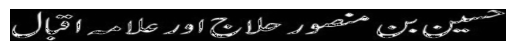

Type Label : <class 'tensorflow.python.framework.ops.EagerTensor'>
Label: [ 26   5  82   0  33  55  34  14  15  78  81   8   5   7   1  10   1  12
  31  19   7   8   9   7   0   8   9  33  55  34  14  15  78  26 131  14
  52  21  27  28  18   1  64  27  36  51  14   2  12   3  58  31  14  10
  85   3  46  64   1 120  14  33   1 999 999 999 999 999 999 999 999 999
 999 999 999 999 999 999 999 999 999 999 999 999 999 999 999 999 999 999
 999 999 999 999 999 999 999 999 999 999 999 999 999 999 999 999 999 999
 999 999 999 999]


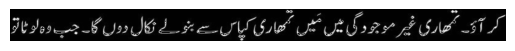

In [ ]:
for image, label in dataset.take(2):
    print(f"Type Label : {type(label)}")
    display_image(image, label)

In [ ]:
# Create the labels and images np arrays for training.
images = []
labels = []

for image, label in dataset:
  labels.append(np.array(label))
  images.append(np.array(image))

In [ ]:
len(images), len(labels), type(images), type(labels)

(30778, 30778, list, list)

In [ ]:
# images = np.array(images) #/255.0 # Normalize the Images
# labels = np.array(labels)

In [ ]:
# len(images), len(labels), type(images), type(labels)


# Train Test Split

*  Total Number of Samples in the dataset are 30778




In [ ]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size = 0.10)

In [ ]:
lt_pth = "/content/drive/MyDrive/CLE/PdfOcr Training/Datasets/Main_Dataset_30k/labels/lt_char.csv"

df = pd.read_csv(lt_pth)
num_classes = df.shape[0] + 1
num_classes

200

## Important Variable Processing

* **train_y** contains the true labels converted to numbers and padded with -1. The length of each label is equal to max_str_len.
* **train_label_len** contains the length of each true label (without padding)
* **train_input_len** contains the length of each predicted label. The length of all the predicted labels is constant i.e number of timestamps - 2.
* **train_output** is a dummy output for ctc loss.

In [ ]:
train_size = len(X_train)
valid_size= len(X_test)

# Total Number of Train and Validation Instances.
train_size, valid_size

(27700, 3078)

In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

In [ ]:
train_y = y_train
valid_y = y_test

In [ ]:
def remove_999_from_lists(data):
    return [[label for label in sublist if label != 999] for sublist in data]

# Example large lists
# Assuming y_train and y_test are very large lists of lists

# Process y_train in chunks
chunk_size = 1000  # Adjust chunk size based on your data size and available memory
filtered_train_chunks = [remove_999_from_lists(y_train[i:i + chunk_size]) for i in range(0, len(y_train), chunk_size)]
train_label_without_padding = [item for chunk in filtered_train_chunks for item in chunk]

# Process y_test in chunks
filtered_test_chunks = [remove_999_from_lists(y_test[i:i + chunk_size]) for i in range(0, len(y_test), chunk_size)]
valid_label_without_padding = [item for chunk in filtered_test_chunks for item in chunk]

train_label_len = [len(label) for label in train_label_without_padding]
valid_label_len = [len(label) for label in valid_label_without_padding]

train_label_len = np.array(train_label_len)
valid_label_len = np.array(valid_label_len)

In [ ]:
train_label_len[:10], valid_label_len[:10]

(array([62, 67, 59, 63, 62, 63, 33, 56, 62, 67]),
 array([62,  3, 65, 59, 70, 65, 60, 48, 73, 62]))

In [ ]:
num_of_timestamps = 128

train_input_len = np.ones([train_size, 1]) * (num_of_timestamps-2)
valid_input_len = np.ones([valid_size, 1]) * (num_of_timestamps-2)

In [ ]:
train_output = np.zeros([train_size])
valid_output = np.zeros([valid_size])

In [ ]:
train_x = np.array(X_train)
valid_x = np.array(X_test)

train_y = np.array(y_train)
valid_y = np.array(y_test)

# Build the Model

In [ ]:
input_shape = (64, 1000, 1)

# Enable eager execution
tf.config.run_functions_eagerly(True)

# Input layer
input_data = Input(shape=input_shape)

# CNN Layers
x = Conv2D(filters=32, kernel_size=(5, 5), strides=(1, 1), padding='SAME', activation='relu')(input_data)
x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='SAME')(x)

x = Conv2D(filters=64, kernel_size=(5, 5), strides=(1, 2), padding='SAME', activation='relu')(x)
x = MaxPooling2D(pool_size=(1, 2), strides=(1, 2), padding='SAME')(x)

x = Conv2D(filters=128, kernel_size=(5, 5), strides=(1, 2), padding='SAME', activation='relu')(x)
x = MaxPooling2D(pool_size=(1, 2), strides=(1, 2), padding='SAME')(x)

x = Conv2D(filters=128, kernel_size=(5, 5), strides=(1, 2), padding='SAME', activation='relu')(x)
x = MaxPooling2D(pool_size=(1, 2), strides=(1, 2), padding='SAME')(x)

x = Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 2), padding='SAME', activation='relu')(x)
x = MaxPooling2D(pool_size=(1, 2), strides=(1, 2), padding='SAME')(x)

x = Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 2), padding='SAME', activation='relu')(x)
x = MaxPooling2D(pool_size=(1, 2), strides=(1, 2), padding='SAME')(x)

x = Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), padding='SAME', activation='relu')(x)
x = MaxPooling2D(pool_size=(1, 1), strides=(1, 1), padding='SAME')(x)

# Flatten Layer
x = Flatten()(x)

# Reshape Layer
x = Reshape((128, 128))(x)  # Adjust the reshape dimensions based on the Flatten output
x = Dense(num_of_timestamps, activation='relu', kernel_initializer='he_normal', name='dense1')(x)

# Bidirectional LSTM Layers
x = Bidirectional(LSTM(units=512, return_sequences=True))(x)
x = Bidirectional(LSTM(units=512, return_sequences=True))(x)

# Dropout Layer
x = Dropout(0.2)(x)

# Output Layer
y_pred = Dense(units=num_classes, activation='softmax')(x)

# Define the model
model = Model(inputs=input_data, outputs=y_pred)


In [ ]:
# the ctc loss function
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    # the 2 is critical here since the first couple outputs of the RNN
    # tend to be garbage
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)


def levenshtein_distance(y_true, y_pred):
    batch_size = K.shape(y_true)[0]
    total_distance = 0.0

    for i in range(batch_size):
        true_seq = ''.join([chr(int(c)) for c in y_true[i] if c > 0])
        pred_seq = ''.join([chr(int(c)) for c in y_pred[i] if c > 0])

        total_distance += Levenshtein.distance(true_seq, pred_seq)

    return total_distance / K.cast(batch_size, K.floatx())



In [ ]:
labels = Input(name='gtruth_labels', shape=[max_str_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

ctc_loss = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])
model_final = Model(inputs=[input_data, labels, input_length, label_length], outputs=ctc_loss)

In [ ]:
# the loss calculation occurs elsewhere, so we use a dummy lambda function for the loss
file_path_best = "C_LSTM_best.hdf5"

model_final.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=Adam(lr = 0.0001), metrics=['accuracy', levenshtein_distance])

checkpoint = ModelCheckpoint(filepath=file_path_best,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='min')

callbacks_list = [checkpoint]

In [ ]:
history = model_final.fit(
    x=[train_x, train_y, train_input_len, train_label_len],
    y=train_output,validation_data=([valid_x, valid_y, valid_input_len, valid_label_len], valid_output),
    callbacks=callbacks_list,
    verbose=1,
    epochs=60,
    batch_size=4,
    shuffle=True,
    )

In [ ]:
model.save('/content/drive/MyDrive/ocr/first_model.h5')